# Introduction

**1.1 What is Pulmonary fibrosis?**

- Pulmonary fibrosis is a lung disease that occurs when lung tissue becomes damaged and scarred. This thickened, stiff tissue makes it more difficult for your lungs to work properly. 


- Video link: https://www.youtube.com/watch?time_continue=1&v=AfK9LPNj-Zo&feature=emb_logo

**1.2 What is OSIC Pulmonary Fibrosis Progression Competition?**

- Predict a patient's severity of decline in 'Lung Function' based on CT scan of their lungs
- 'Lung Function' capacity is accessed using Spirometer which measures FVC (Forced Vital Capacity) - the volume of air exhaled


<font color='green'> **1.3 Data:** </font>

- You are provided with a baseline chest CT scan and associated clinical information for a set of patients. 

- A patient has an image acquired at time Week = 0 and has numerous follow up visits over the course of approximately 1-2 years, at which time their FVC is measured.


- **Train, Test Data**
    - In the training set, you are provided with an anonymized, baseline CT scan and the entire history of FVC measurements.
    - In the test set, you are provided with a baseline CT scan and only the initial FVC measurement. **You are asked to predict the final three FVC measurements for each patient, as well as a confidence value in your prediction.**
    
Note: Since this is real medical data, you will notice the relative timing of FVC measurements varies widely. The timing of the initial measurement relative to the CT scan and the duration to the forecasted time points may be different for each patient. This is considered part of the challenge of the competition. To avoid potential leakage in the timing of follow up visits, you are asked to <font color="blue">**predict every patient's FVC measurement for every possible week.** </font> Those weeks which are not in the final three visits are ignored in scoring.

**1.4 Files:**

- This is a synchronous rerun code competition. The provided test set is a small representative set of files (copied from the training set) to demonstrate the format of the private test set. When you submit your notebook, Kaggle will rerun your code on the test set, which contains unseen images.

    - train.csv - the training set, contains full history of clinical information
    - test.csv - the test set, contains only the baseline measurement
    - train/ - contains the training patients' baseline CT scan in DICOM format
    - test/ - contains the test patients' baseline CT scan in DICOM format
    - sample_submission.csv - demonstrates the submission format
    

**1.5 Columns:**

- **train.csv and test.csv**
    - Patient- a unique Id for each patient (also the name of the patient's DICOM folder)
    - Weeks- the relative number of weeks pre/post the baseline CT (may be negative)
    - FVC - the recorded lung capacity in ml
    - Percent- a computed field which approximates the patient's FVC as a percent of the typical FVC for a person of similar characteristics
    - Age
    - Sex
    - SmokingStatus

- **1.6 sample submission.csv**
    - Patient_Week - a unique Id formed by concatenating the Patient and Weeks columns (i.e. ABC_22 is a prediction for -patient ABC at week 22)
    - FVC - the predicted FVC in ml
    - Confidence - a confidence value of your prediction (also has units of ml)

# Evaluation Metric of the competition

- The evaluation metric of this competition is a modified version of Laplace Log Likelihood.


- In medical applications, it is useful to evaluate a model's confidence in its decisions.


- <font color="orange">**Accordingly, the metric is designed to reflect BOTH THE ACCURACY AND CERTAINTYof each prediction.** </font>


- For each true FVC measurement, you will predict both an FVC and a confidence measure (standard deviation σ). The metric is computed as:


        σclipped=max(σ,70),

        Δ=min(|FVCtrue−FVCpredicted|,1000),

        metric= −2*(√Δ/σclipped)−ln(2‾√σclipped).

    
Note: The error is thresholded at 1000 ml to avoid large errors adversely penalizing results, while the confidence values are clipped at 70 ml to reflect the approximate measurement uncertainty in FVC. The final score is calculated by averaging the metric across all test set Patient_Weeks (three per patient). Note that metric values will be negative and higher is better.

## Understanding Laplace Log Likelihood

In [66]:
## importing packages
# !pip install bokeh
import numpy as np
import pandas as pd
import seaborn as sns

from bokeh.layouts import row, column
from bokeh.models import ColumnDataSource, CustomJS, Label, Range1d, Slider, Span
from bokeh.plotting import figure, output_notebook, show
output_notebook()

# read train data
df_train = pd.read_csv("../input/osic_lung_pulnomary/train.csv")



Loading BokehJS ...

## FVC Distribution

FVC Min --> 827
FVC Max --> 6399


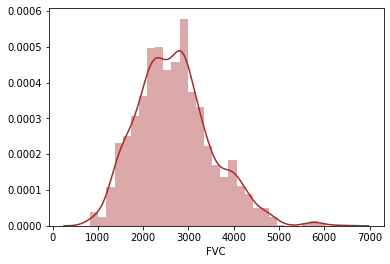

In [70]:
print(f"FVC Min --> {np.min(df_train.FVC)}")
print(f"FVC Max --> {np.max(df_train.FVC)}")

sns.distplot(df_train.FVC, color="brown")

## Evaluation metric

- Note that **not only do we need to predict the FVC but also a confidence value of the prediction.**
- The term confidence is a bit confusing (as lower value means more confident) and it might be better to just consider it as the standard deviation (or the uncertainty).

In [69]:
## evaluation metric function

def laplace_log_likelihood(actual_fvc, predicted_fvc, confidence, return_values=False):
    """
    Calculates the modified Log Likelihood score for OSIC Pulmonary Fibrosis Competition
    """
    sd_clipped = np.maximum(confidence, 70)
    delta = np.minimum(np.abs(actual_fvc-predicted_fvc), 1000)
    metric = - np.sqrt(2) * delta / sd_clipped - np.log(np.sqrt(2) * sd_clipped)
    
    if return_values:
        return metric
    else:
        return np.mean(metric)

## Default Benchmark (Baseline)

In [72]:
laplace_log_likelihood(df_train.FVC, np.mean(df_train.FVC), np.std(df_train.FVC))

-8.023182671302116

**Note:**  

- 8.023 is the default score to beat while cross-validating models on train data. Any model scoring worse than this is not useful.

- You can get this default score to beat for each (fold of) validation data as well.
